In [19]:
from event_table import event_table
from plot_event import plot_event
import matplotlib.pyplot as plt
from calc_price import *
import numpy as np

In [20]:
# Issues: getting the right thermostat data -- hsp, csp, IAT not the columns
# some event days dont work
# get the mapping from the MDAL queries
# BASELINE: SCE 10 days before 
# get energy consumed in even vs baseline 
site = 'ciee'
start = '2018-05-03T00:00:00Z'
end = '2018-07-12T00:00:00Z'
event_day = '2018-06-15T00:00:00'
event_start_hour = 14
event_end_hour = 18

tbl = event_table(site, event_day, start, end, 14, 18, max_baseline=True);

0


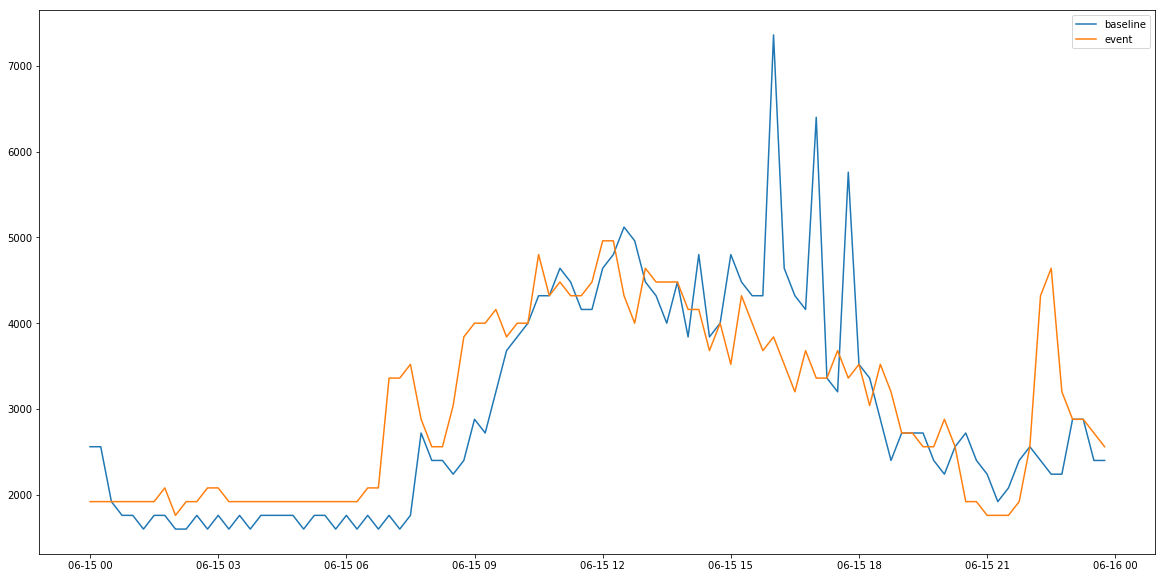

In [3]:
df = tbl['df']
plt.figure(figsize=(20, 10))
plt.plot(df['baseline-demand'], label='baseline')
plt.plot(df['event-demand'], label='event')
plt.legend()

In [5]:
tbl['df'].head()

,baseline-demand,event-demand,baseline-weather,event-weather,baseline-IAT,event-IAT
2018-06-15 00:00:00,2560.0,1920.0,55.940022,53.462753,NaN,76.236628
2018-06-15 00:15:00,2560.0,1920.0,55.869819,53.462753,NaN,76.141104
2018-06-15 00:30:00,1920.0,1920.0,56.450309,53.462753,NaN,76.031496
2018-06-15 00:45:00,1760.0,1920.0,56.730211,53.462753,NaN,75.649845
2018-06-15 01:00:00,1760.0,1920.0,56.544819,54.543647,NaN,75.625000


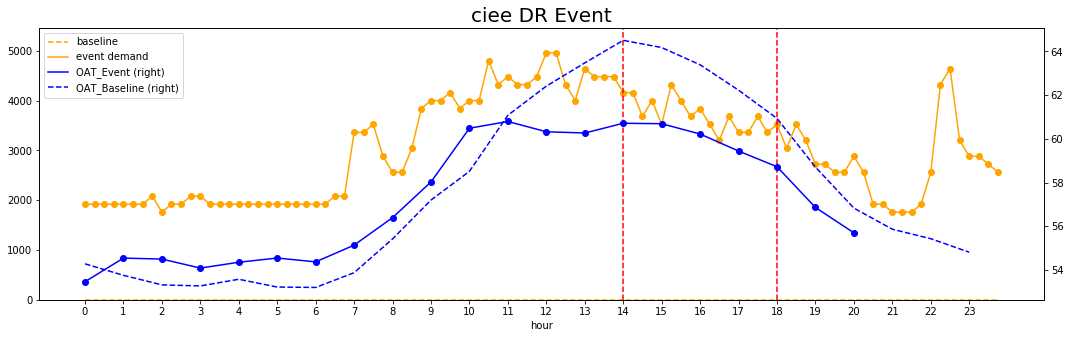

<Figure size 432x288 with 0 Axes>

In [6]:
plot_event(site, event_day, start, end, 14, 18);

In [7]:
options =  {
        'utility_id': '14328',
        'sector': 'Commercial',
        'tariff_rate_of_interest': 'A-1 Small General Service', 
        'distrib_level_of_interest': None, 
        'phasewing': 'Single',
        'tou': True
    }

In [22]:
def agg_tbl(table, event_start_hr, event_end_hr, tariff_opts):
    date = str(table.index[0].date())
    energy_baseline = power_15min_to_hourly_energy(table['baseline-demand'])
    energy_event = power_15min_to_hourly_energy(table['event-demand'])
    full_day_baseline = sum(energy_baseline)
    full_day_event = sum(energy_event)
    window_baseline = sum(energy_baseline[(energy_baseline.index >= event_start_hr) & (energy_baseline.index <= event_end_hr)])
    window_event = sum(energy_event[(energy_event.index >= event_start_hr) & (energy_event.index <= event_end_hr)])
    baseline_cost = calc_total_price(table['baseline-demand'], tariff_opts, table['event-demand'].index[0], table['event-demand'].index[-1])
    event_cost = calc_total_price(table['event-demand'], tariff_opts, table['event-demand'].index[0], table['event-demand'].index[-1])
    event_peak_temp = max(table['event-weather'])
    baseline_peak_temp = max(table['baseline-weather'])
    max_demand_baseline = max(table['baseline-demand'])
    max_demand_event = max(table['event-demand'])
    return {
        'date': date,
        'baseline_full': full_day_baseline,
        'event_full': full_day_event,
        'baseline_window': window_baseline,
        'event_window': window_event,
        'baseline_peak_demand': max_demand_baseline,
        'event_peak_demand': max_demand_event,
        'baseline_cost': baseline_cost,
        'event_cost': event_cost,
        'event_peak_temp': event_peak_temp,
        'baseline_peak_temp': baseline_peak_temp
    }
    

In [18]:
events = pd.read_json('./pricing/openei_tariff/PDP_events.json')

In [19]:
pge = events[events['utility_id'] == 14328]

In [45]:
def add_days(dt, days):
    date_time = (pd.to_datetime(dt) + pd.to_timedelta(days, unit='day'))
    result = str(date_time.date()) + 'T00:00:00Z'
    return result

In [21]:
site='ciee'

# tables = pge.apply(lambda r: event_table(site, r['start_date'], add_days(r['start_date'], -11), add_days(r['start_date'], 1))), axis=1

In [22]:
pge.head()

,end_date,start_date,utility_id
11,2018-06-12T23:00:00-08:00,2018-06-12T00:00:00-08:00,14328
12,2018-06-13T23:00:00-08:00,2018-06-13T00:00:00-08:00,14328
13,2018-07-10T23:00:00-08:00,2018-07-10T00:00:00-08:00,14328
14,2018-07-16T23:00:00-08:00,2018-07-16T00:00:00-08:00,14328
15,2018-07-17T23:00:00-08:00,2018-07-17T00:00:00-08:00,14328


In [25]:
dfs = [t['df'] for t in tables]

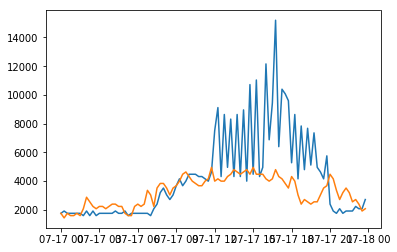

In [26]:
example = dfs[4]
baseline = example['baseline-demand']
event = example['event-demand']
plt.plot(baseline)
plt.plot(event)

In [32]:
ciee_events.to_csv('max_temp_baseline.csv')

In [32]:
tables = pge.apply(lambda r: event_table(site, r['start_date'][:-6], add_days(r['start_date'], -40), add_days(r['start_date'], 40), max_baseline=True, offset=2), axis=1)
dfs = [t['df'] for t in tables]
ciee_events = [agg_tbl(df, 14, 18, options) for df in dfs]
ciee_events = pd.DataFrame(ciee_events)[[
        'date',
        'baseline_full',
        'event_full',
        'baseline_window',
        'event_window',
        'baseline_peak_demand',
        'event_peak_demand',
        'baseline_cost',
        'event_cost',
        'event_peak_temp',
        'baseline_peak_temp',
    ]]
ciee_events['savings'] = ciee_events['baseline_cost'] - ciee_events['event_cost']
ciee_events['event_energy_savings'] = ciee_events['baseline_window'] - ciee_events['event_window']
ciee_events

2
2
2
2
2
2
2
2
2


,date,baseline_full,event_full,baseline_window,event_window,baseline_peak_demand,event_peak_demand,baseline_cost,event_cost,event_peak_temp,baseline_peak_temp,savings,event_energy_savings
0,2018-06-12,72920.0,107200.0,19600.0,32480.0,4640.0,11360.0,26.854964,42.472678,75.375050,71.7296,-15.617714,-12880.0
1,2018-06-13,72920.0,102840.0,19600.0,35760.0,4640.0,15680.0,26.854964,43.718368,74.734700,71.7296,-16.863404,-16160.0
2,2018-07-10,72920.0,104800.0,19600.0,34440.0,4640.0,16320.0,26.854964,44.031210,76.328825,71.7296,-17.176246,-14840.0
3,2018-07-16,70680.0,70640.0,19680.0,17280.0,4320.0,6080.0,26.085878,25.049276,66.845300,71.0600,1.036602,2400.0
4,2018-07-17,70680.0,78080.0,19680.0,20880.0,4320.0,4960.0,26.085878,28.662868,68.152550,71.0600,-2.576990,-1200.0
5,2018-07-19,70680.0,76280.0,19680.0,21840.0,4320.0,6240.0,26.085878,28.973994,68.270000,71.0600,-2.888116,-2160.0
6,2018-07-24,70680.0,72480.0,19680.0,19400.0,4320.0,4960.0,26.085878,26.754134,69.665000,71.0600,-0.668256,280.0
7,2018-07-25,70680.0,68160.0,19680.0,19680.0,4320.0,4480.0,26.085878,25.752420,71.484800,71.0600,0.333458,0.0
8,2018-07-27,70680.0,63880.0,19680.0,17520.0,4320.0,4320.0,26.085878,23.966564,64.545350,71.0600,2.119314,2160.0


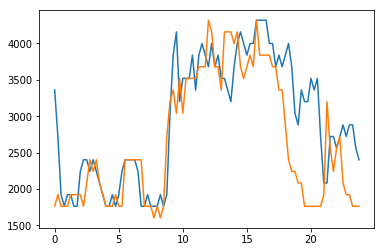

In [16]:
plt.plot(np.arange(0, 24, 0.25), dfs[8]['baseline-demand'])
plt.plot(np.arange(0, 24, 0.25), dfs[8]['event-demand'])

In [ ]:
import dataclient
m = dataclient.MDALClient("corbusier.cs.berkeley.edu:8088")

In [ ]:
start = '2018-05-01T00:00:00Z'
end = '2018-11-01T00:00:00Z'

In [ ]:
request = {
    "Variables": {
            "weather": {
                "Definition": """SELECT ?t ?t_uuid FROM %s WHERE {
                    ?t rdf:type/rdfs:subClassOf* brick:Weather_Temperature_Sensor .
                    ?t bf:uuid ?t_uuid
                };""" % site,
            }
    }
}

In [ ]:
request['Composition'] = ['weather']
request['Aggregation'] = {'weather': ['MAX']}
request['Time'] = {
    'Start': start,
    'End': end,
    'Window': '24h',
    'Aligned': True
}

In [ ]:
esp_weather = m.query(request)

In [ ]:
df = esp_weather.df

In [ ]:
mean = df.mean(axis=1)

In [ ]:
day = mean.sort_values(ascending=False).index[0]

In [ ]:
from collect import get_weather_power_tstat

In [ ]:
day_after = day + pd.DateOffset(1)

In [ ]:
result = get_weather_power_tstat('ciee', str(day.date()) + 'T00:00:00Z', str((day + pd.DateOffset(1)).date()) + 'T00:00:00Z')

In [ ]:
str(day.date()) + 'T00:00:00Z'

In [ ]:
str(day.date()) + 'T00:00:00Z'

In [ ]:
str(day.date())

In [ ]:
result['weather'].df

In [ ]:
pd.read_csv('')

In [21]:


tables = pge.apply(lambda r: event_table(site, r['start_date'][:-6], add_days(r['start_date'], -40), add_days(r['start_date'], 40), max_baseline=True, offset=2), axis=1)
dfs = [t['df'] for t in tables]
ciee_events = [agg_tbl(df, 14, 18, options) for df in dfs]
ciee_events = pd.DataFrame(ciee_events)[[
        'date',
        'baseline_full',
        'event_full',
        'baseline_window',
        'event_window',
        'baseline_peak_demand',
        'event_peak_demand',
        'baseline_cost',
        'event_cost',
        'event_peak_temp',
        'baseline_peak_temp',
    ]]
ciee_events['savings'] = ciee_events['baseline_cost'] - ciee_events['event_cost']
ciee_events['event_energy_savings'] = ciee_events['baseline_window'] - ciee_events['event_window']
ciee_events

NameError: name 'pge' is not defined

In [39]:
tarrifs = pd.read_csv('./tariffs.csv', index_col='meter_id')

In [40]:
tarrifs

,distrib_level_of_interest,option_exclusion,phasewing,sector,tariff_rate_of_interest,tou,utility_id
meter_id,,,,,,,
4c95836f-6bdb-3adc-ac5e-4c787ae027c7,Secondary,NaN,NaN,Commercial,A-10,True,14328
4d95d5ce-de62-3449-bd58-4dcad75b526d,NaN,NaN,Single,Commercial,A-1 Small General Service,True,14328
d2ad6682-8e44-374b-8bfe-9e25960a9be0,NaN,NaN,Single,Commercial,A-1 Small General Service,True,14328
e9c51ce5-4aa1-399c-8172-92073e273a0b,NaN,"['(X}', '(W}', 'Poly']",NaN,Commercial,A-6,True,14328
68e04192-e924-36b8-9c5e-f072bd93ed07,Secondary,"['Option R', 'Voluntary']",NaN,Commercial,E-19,True,14328
849cae1e-5714-34e1-8a4e-ec72ca71b0ab,NaN,NaN,Single,Commercial,A-1 Small General Service,True,14328
a373b62e-04f3-3c1e-b27d-279f792f4b18,Secondary,NaN,NaN,Commercial,A-10,True,14328
a22be94b-c525-3442-88d3-936dc58de0be,NaN,NaN,Single,Commercial,A-1 Small General Service,True,14328
8a2f69f5-38f7-3e39-90bd-370a3aa38b77,NaN,NaN,Single,Commercial,A-1 Small General Service,True,14328


In [25]:
site = 'avenal-animal-shelter'

In [29]:
events = pd.read_json('./pricing/openei_tariff/PDP_events.json')

In [30]:
events.head()

,end_date,start_date,utility_id
0,2018-07-06T23:00:00-08:00,2018-07-06T00:00:00-08:00,17609
1,2018-07-09T23:00:00-08:00,2018-07-09T00:00:00-08:00,17609
2,2018-07-10T23:00:00-08:00,2018-07-10T00:00:00-08:00,17609
3,2018-07-17T23:00:00-08:00,2018-07-17T00:00:00-08:00,17609
4,2018-07-18T23:00:00-08:00,2018-07-18T00:00:00-08:00,17609


In [31]:
from get_greenbutton_id import get_greenbutton_id

In [35]:
meter_id = get_greenbutton_id(site, "2018-01-01T10:00:00-07:00", "2018-08-12T10:00:00-07:00")[0]
meter_id

'f9ba6d7e-d730-31d7-95fb-d7ec0e4ab765'

In [41]:
tariff = tarrifs.loc[meter_id]
tariff

distrib_level_of_interest                          NaN
option_exclusion                                   NaN
phasewing                                       Single
sector                                      Commercial
tariff_rate_of_interest      A-1 Small General Service
tou                                               True
utility_id                                       14328
Name: f9ba6d7e-d730-31d7-95fb-d7ec0e4ab765, dtype: object

In [43]:
utility_events = events[events['utility_id'] == tariff.utility_id]
utility_events

,end_date,start_date,utility_id
11,2018-06-12T23:00:00-08:00,2018-06-12T00:00:00-08:00,14328
12,2018-06-13T23:00:00-08:00,2018-06-13T00:00:00-08:00,14328
13,2018-07-10T23:00:00-08:00,2018-07-10T00:00:00-08:00,14328
14,2018-07-16T23:00:00-08:00,2018-07-16T00:00:00-08:00,14328
15,2018-07-17T23:00:00-08:00,2018-07-17T00:00:00-08:00,14328
16,2018-07-19T23:00:00-08:00,2018-07-19T00:00:00-08:00,14328
17,2018-07-24T23:00:00-08:00,2018-07-24T00:00:00-08:00,14328
18,2018-07-25T23:00:00-08:00,2018-07-25T00:00:00-08:00,14328
19,2018-07-27T23:00:00-08:00,2018-07-27T00:00:00-08:00,14328


In [49]:
tables = utility_events.apply(lambda r: event_table(site, r['start_date'][:-6], add_days(r['start_date'], -40), add_days(r['start_date'], 40), max_baseline=True, offset=2), axis=1)
dfs = [t['df'] for t in tables]
ciee_events = [agg_tbl(df, 14, 18, tariff) for df in dfs]
ciee_events = pd.DataFrame(ciee_events)[[
        'date',
        'baseline_full',
        'event_full',
        'baseline_window',
        'event_window',
        'baseline_peak_demand',
        'event_peak_demand',
        'baseline_cost',
        'event_cost',
        'event_peak_temp',
        'baseline_peak_temp',
    ]]
ciee_events['savings'] = ciee_events['baseline_cost'] - ciee_events['event_cost']
ciee_events['event_energy_savings'] = ciee_events['baseline_window'] - ciee_events['event_window']
ciee_events

2
2
2
2
2
2
2
2
2
cant open file


TypeError: 'NoneType' object is not iterable

In [52]:
import math

In [53]:
math

<module 'math' from '/Users/jleyden/anaconda3/envs/mortar/lib/python3.6/lib-dynload/math.cpython-36m-darwin.so'>

In [1]:
import pandas as pd

In [2]:
x = ! ls ./daily

In [3]:
dfs = {}
for e in x:
    if '_events' in e:
        site = e[:-11]
    else:
        site = e[:-4]
    df = pd.read_csv('./daily/' + e)
    dfs[site] = df

In [4]:
dfs.keys()

dict_keys(['avenal-animal-shelter', 'avenal-movie-theatre', 'avenal-public-works-yard', 'avenal-recreation-center', 'avenal-veterans-hall', 'berkeley-corporate-yard', 'ciee', 'hayward-station-1', 'hayward-station-8', 'north-berkeley-senior-center', 'orinda-community-center', 'south-berkeley-senior-center', 'word-of-faith-cc'])

In [5]:
dfs['south-berkeley-senior-center']

,Unnamed: 0,date,baseline_full,event_full,baseline_window,event_window,baseline_peak_demand,event_peak_demand,baseline_cost,event_cost,event_peak_temp,baseline_peak_temp,savings,event_energy_savings
0,0,2018-06-12,205440.0,253280.0,51680.0,48720.0,21440.0,24320.0,77.140296,83.396120,75.375050,71.7296,-6.255824,2960.0
1,1,2018-06-13,205440.0,197120.0,51680.0,45840.0,21440.0,18880.0,77.140296,67.367804,74.734700,71.7296,9.772492,5840.0
2,2,2018-07-10,205440.0,230320.0,51680.0,61360.0,21440.0,27200.0,77.140296,88.139008,76.328825,71.7296,-10.998712,-9680.0
3,3,2018-07-16,238880.0,230800.0,61360.0,58640.0,21120.0,21120.0,87.972876,86.071948,66.845300,71.0600,1.900928,2720.0
4,4,2018-07-17,238880.0,286160.0,61360.0,51760.0,21120.0,29760.0,87.972876,94.685160,68.152550,71.0600,-6.712284,9600.0
5,5,2018-07-19,238880.0,319760.0,61360.0,69280.0,21120.0,31360.0,87.972876,112.663652,68.270000,71.0600,-24.690776,-7920.0
6,6,2018-07-24,238880.0,303920.0,61360.0,66640.0,21120.0,29120.0,87.972876,108.214284,69.665000,71.0600,-20.241408,-5280.0
7,7,2018-07-25,238880.0,237760.0,61360.0,71360.0,21120.0,20480.0,87.972876,92.601888,71.484800,71.0600,-4.629012,-10000.0
8,8,2018-07-27,238880.0,224000.0,61360.0,56400.0,21120.0,21760.0,87.972876,83.354864,64.545350,71.0600,4.618012,4960.0


In [6]:
all_dates = set()
for site in dfs:
    df = dfs[site]
    df.index = df['date']
    for date in df.index:
        all_dates.add(date)
    dfs[site] = df

In [7]:
list(all_dates)

['2018-06-13',
 '2018-07-17',
 '2018-07-16',
 '2018-07-27',
 '2018-06-12',
 '2018-07-10',
 '2018-07-24',
 '2018-07-25',
 '2018-07-19']

In [8]:
for d in dfs:
    df = dfs[d]
    df['site'] = d
    dfs[d] = df

## Energy Savings (2-6pm in Wh)

In [9]:
data_key = 'event_energy_savings'
result = {}
for d in dfs:
    df =  dfs[d]
    data = df.T.loc[data_key]
    result[d] = data

In [10]:
pd.DataFrame(result)

,avenal-animal-shelter,avenal-movie-theatre,avenal-public-works-yard,avenal-recreation-center,avenal-veterans-hall,berkeley-corporate-yard,ciee,hayward-station-1,hayward-station-8,north-berkeley-senior-center,orinda-community-center,south-berkeley-senior-center,word-of-faith-cc
date,,,,,,,,,,,,,
2018-06-12,5816,49920,NaN,-2990.1,17840,-43040,-12880,-55360,-6344,18000,-72672,2960,5702.5
2018-06-13,6904,50640,NaN,-5038.6,24880,-65120,-16160,-20400,752,-4880,-53840,5840,5094.5
2018-07-10,15488,-51240,2640,5502,15600,13280,-14840,1360,6216,0,-23720,-9680,16484.5
2018-07-16,17408,0,2400,10742.3,11600,34400,2400,9120,0,0,-15456,2720,16904.5
2018-07-17,14384,0,4320,21893.5,13120,24320,-1200,7200,0,0,8376,9600,17436.5
2018-07-19,25248,0,2240,15170.3,2800,28320,-2160,6000,0,0,4408,-7920,11485.5
2018-07-24,14664,0,-80,887.2,2800,14720,280,-7840,0,0,-20824,-5280,17441.5
2018-07-25,13960,0,-720,-8692,10000,4800,0,1760,0,0,-19816,-10000,15632.5
2018-07-27,14256,0,1440,-4082.3,32400,16000,2160,57120,0,0,31888,4960,12766.5


## Dollar savings

In [11]:
data_key = 'savings'
result = {}
for d in dfs:
    df =  dfs[d]
    data = df.T.loc[data_key]
    result[d] = data

In [12]:
pd.DataFrame(result)

,avenal-animal-shelter,avenal-movie-theatre,avenal-public-works-yard,avenal-recreation-center,avenal-veterans-hall,berkeley-corporate-yard,ciee,hayward-station-1,hayward-station-8,north-berkeley-senior-center,orinda-community-center,south-berkeley-senior-center,word-of-faith-cc
date,,,,,,,,,,,,,
2018-06-12,11.1003,0,NaN,2.10963,28.112,0,-15.6177,-65.3333,0,0,0,-6.25582,10.4381
2018-06-13,11.7569,0,NaN,-1.92539,19.2684,0,-16.8634,-29.7206,0,0,0,9.77249,10.0473
2018-07-10,16.8117,0,2.15758,8.80842,19.3109,0,-17.1762,-9.88276,0,0,0,-10.9987,20.3416
2018-07-16,17.6852,0,1.11238,6.5181,13.1759,0,1.0366,-4.91453,0,0,0,1.90093,21.2789
2018-07-17,12.8402,0,4.59209,19.3045,16.7515,0,-2.57699,-2.54461,0,0,0,-6.71228,21.1797
2018-07-19,21.3017,0,2.23418,14.1517,2.74096,0,-2.88812,-6.08522,0,0,0,-24.6908,16.2978
2018-07-24,14.3553,0,0.97166,7.29046,6.54296,0,-0.668256,-20.8608,0,0,0,-20.2414,21.2969
2018-07-25,9.86443,0,-1.05694,-0.568967,7.29944,0,0.333458,-14.4822,0,0,0,-4.62901,19.5092
2018-07-27,10.6765,0,1.86486,-6.83711,32.9393,0,2.11931,42.8647,0,0,0,4.61801,16.6444
